# Adversial Example Generation

Use one of the first and most popular attack methods, the Fast Gradient Sign Attack (FGSM), to fool an MNIST classifier. It is designed to attack neural networks by leveraging the way they learn, gradients. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

## Threat Model

In general, the overarching goal is to add the least amount of perturbation to the input data to cause the desired misclassification.

Assumptions of attacker's knowledge:
- **White-Box Attack**: Assumption that the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights.
- **Black-Box Attack**: Assumption that the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights.
 
Types of goals:
- **Misclassification**: Adversary only wants the output misclassification to be wrong but does not care what the new classification is.
- **Source/Target Misclassification**: Adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class

FGSM Attack: white-box attack with the goal of misclassification.

## Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Input Parameters

In [2]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = "data/lenet_mnist_model.pth.pt"
use_cuda = True
# Set random seed for reproducibility
torch.manual_seed(42)

### Model Under Attack

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, shuffle=True)

# Define what device will be used
print(f"MPS Available: {torch.backends.mps.is_available()}")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

# Initilaize network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set model in evaluation mode. 
model.eval()


MPS Available: True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### FGSM Attack

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect element-wise sign of data gradient
    sign_data_grad = data_grad.sign()
    # Create perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return perturbed image
    return perturbed_image

# Restores tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors
        mean (torch.Tensor or list): Mean used for normalization
        std (torch.Tensor or list): Standard deviation used for normalization

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Testing Function

In [5]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send data and label to device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass data through model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # Get index of max log-probability

        # If initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ''datagrad''
        data_grad = data.grad.data

        # Restore data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # Get index of max log-probability

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples fro visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy: {correct}/{len(test_loader)} = {final_acc}")

    # Return accuracy and adversial example
    return final_acc, adv_examples

### Run Attack

In [6]:
accuracies =  []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy: 9912/10000 = 0.9912
Epsilon: 0.05	Test Accuracy: 9606/10000 = 0.9606
Epsilon: 0.1	Test Accuracy: 8743/10000 = 0.8743
Epsilon: 0.15	Test Accuracy: 7113/10000 = 0.7113
Epsilon: 0.2	Test Accuracy: 4867/10000 = 0.4867
Epsilon: 0.25	Test Accuracy: 2713/10000 = 0.2713
Epsilon: 0.3	Test Accuracy: 1416/10000 = 0.1416


## Results

### Accuracy vs. Epsilon

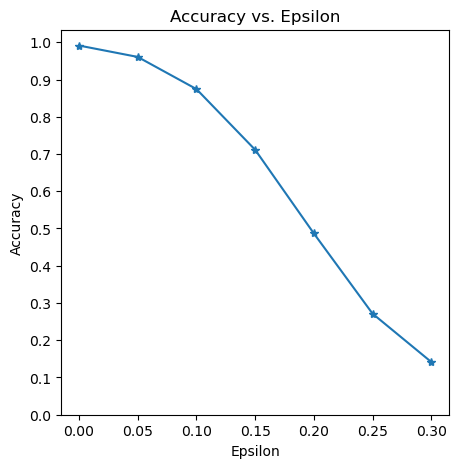

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversial Examples

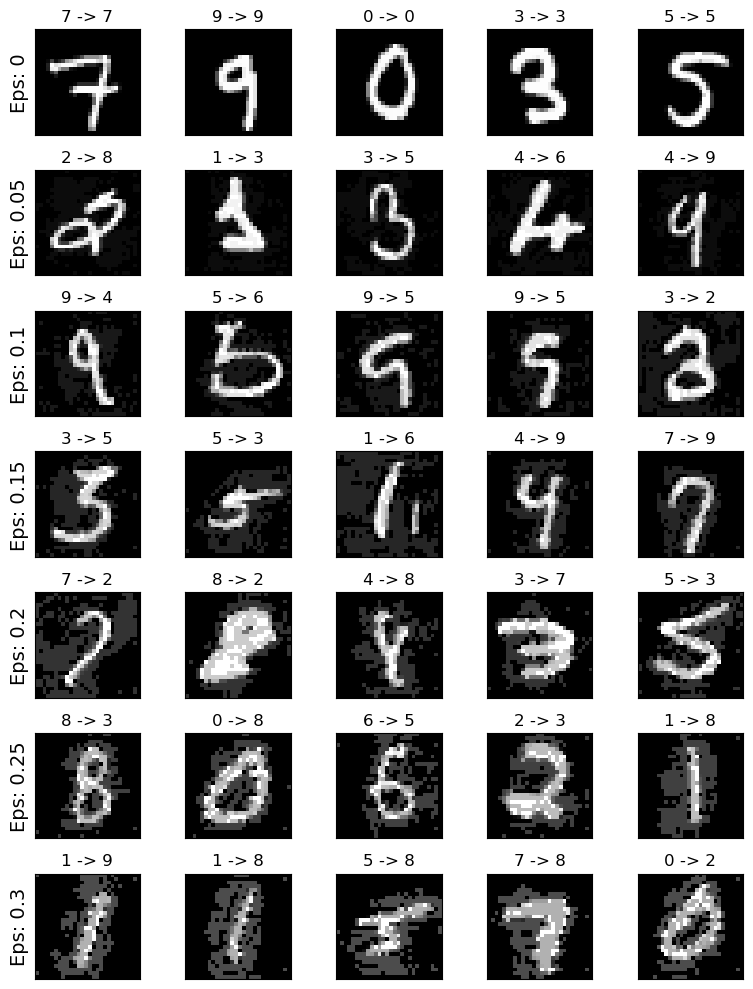

In [8]:
# Plot several examples of adversial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()